# Segment the cell

In [1]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.types import SimulationParameters, ConstantCurrentInjection

import matplotlib.pyplot as plt
import numpy as np

## Step 1: Identify functional modules

Based on the channels present in the soma of our model, we identified the following functional modules:
1. Passive (H; <71.7 mV)
2. LTO (Nap, KM, KT; >-71.7 mV)
3. Spiking (NaTa, Kdr; >-60 mV)
4. Bursting (CaLVA, CaHVA, Kv2, Kv3; >-40 mV)

Additionally, e-leak = -71.7 mV.

## Step 2: Set the activation functions

Transfer the activation functions from the modfiles and plot them. We additionally plot e-leak for reference.

The segmentation procedure is implemented in the `ACTSegregator` module. It outputs segmented activation functions together with the text to update the modfiles. The procedure requires the specification of 2 parameters:
- `cutoff_v`: the left (right for the H channel) bound of the module.
- `extrapolate_dv`: the length of the linear extrapolation segment.

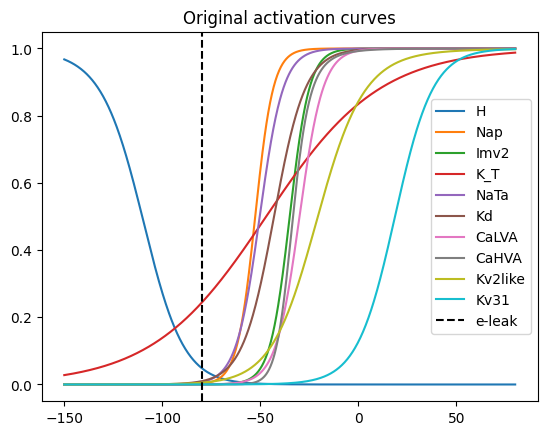

In [15]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

def H(v):
    mAlpha = 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
    mBeta  =  0.001*193*np.exp(v/33.1)
    return mAlpha/(mAlpha + mBeta)

def NaTa(v):
    malphaF = 0.182
    mbetaF = 0.124
    mvhalf = -48
    mk = 6
    mAlpha = malphaF * vtrap(-(v - mvhalf), mk)
    mBeta = mbetaF * vtrap((v - mvhalf), mk)
    mInf = mAlpha/(mAlpha + mBeta)
    return mInf

def Nap(v):
    return 1.0/(1+np.exp((v- -52.6)/-4.6))

def Kd(v):
    return 1 - 1 / (1 + np.exp((v - (-43)) / 8))

def Kv2like(v):
    mAlpha = 0.12 * vtrap( -(v - 43), 11.0)
    mBeta = 0.02 * np.exp(-(v + 1.27) / 120)
    return mAlpha/(mAlpha + mBeta)

def Kv31(v):
    return 1/(1+np.exp(((v -(18.700 + 0))/(-9.700))))

def K_T(v): # Transient potassium
    return 1/(1 + np.exp(-(v - (-47 + 0)) / 29))

def Imv2(v):
    mAlpha = 3.3e-3*np.exp(2.5*0.04*(v - -35))
    mBeta = 3.3e-3*np.exp(-2.5*0.04*(v - -35))
    return mAlpha/(mAlpha + mBeta)

# SK is purely Ca-dependent, skipping
def CaHVA(v):
    mAlpha = 0.055 * vtrap(-27 - v, 3.8)
    mBeta  =  (0.94*np.exp((-75-v)/17))
    return mAlpha/(mAlpha + mBeta)

def CaLVA(v):
    return 1.0000/(1+ np.exp((v - -30.000)/-6))

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([H, Nap, Imv2, K_T, NaTa, Kd, CaLVA, CaHVA, Kv2like, Kv31], ["H", "Nap", "Imv2", "K_T", "NaTa", "Kd", "CaLVA", "CaHVA", "Kv2like", "Kv31"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-79.66, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [12]:
segregator = ACTSegregator()
segregated_passive = segregator.segregate(v, [H(v)], cutoff_v = -79.66)
segregated_lto = segregator.segregate(v = v, activation_curves = [Nap(v), Imv2(v), K_T(v)], cutoff_v = -79.66)
segregated_spiking = segregator.segregate(v = v, activation_curves = [NaTa(v), Kd(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [CaLVA(v), CaHVA(v), Kv2like(v), Kv31(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -81.66) {
        replace_with_var_name = -0.029 * v + -2.289
        }
        if (v > -79.66) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.002 * v + 0.169
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.0 * v + 0.008
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.129 * v + 10.257
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
-------

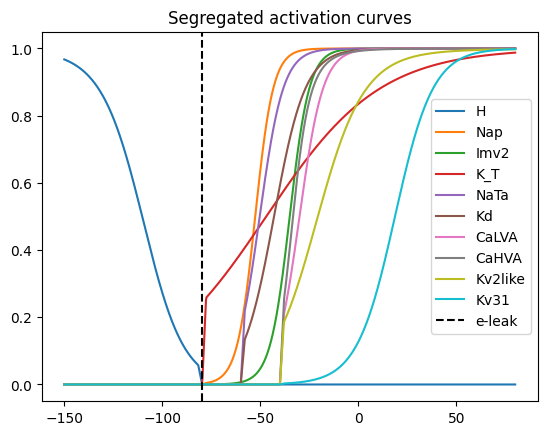

In [13]:
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_lto, ["Nap", "Imv2", "K_T"]):
    plt.plot(v, ac, label = ac_name)    

for ac, ac_name in zip(segregated_spiking, ["NaTa", "Kd"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "Kv2like", "Kv31"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-79.66, color = 'black', ls = '--', label = "e-leak")
plt.legend()

## Step 3: Set the segmented model

Make a copy of the original folder with simulation templates and modfiles and name it `seg`. Update the modfile with the segregator's output (see [example](https://github.com/V-Marco/ACT/tree/main/data/L5)).

## More examples

See [this notebook](https://github.com/V-Marco/ACT/blob/main/experiments/current_segmentation.ipynb) for additional examples on current segmentation.